# CE-40957: Reinforcement Learning
## HW1

*Full name:* Mohammad Kalbasi

*Student number:* 401211028

# Installations and Imports

In [1]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!sudo apt-get install -y xvfb ffmpeg
!pip3 install gymnasium[classic_control]

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,014 kB]
Hit:13 http://ppa.launchpad.net/gr

In [2]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility functions for rendering evironment

In [3]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [4]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        self.feed_forward = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),

           nn.Linear(128, n_actions))
        
        # ==================================== Your Code (End) ====================================

    def forward(self, x):
        # ==================================== Your Code (Begin) ====================================
        output = self.feed_forward(x)
        return(output)
        # ==================================== Your Code (End) ====================================

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [7]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 

# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    # ==================================== Your Code (Begin) ====================================
    with torch.no_grad():
      selected = qnet(state).max(1)[1]
      selected_resized = selected.view(1,1)
      return selected_resized
    # ==================================== Your Code (End) ====================================

In [8]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.

def e_greedy_policy(qnet, state, current_timestep):
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * current_timestep / EPS_DECAY)
    # ==================================== Your Code (Begin) ====================================
    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    uniform_random= random.random()
    if uniform_random <= eps_threshold:
      sampled = env.action_space.sample()
      tensor_output = torch.tensor([[sampled]])
      tensor_output = tensor_output.to(DEVICE)
      return(tensor_output)
    else:
      tensor_output = greedy_policy(qnet, state)
      return(tensor_output)

      

    # ==================================== Your Code (End) ====================================

# Initial setup

In [15]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)
target_network.load_state_dict(q_network.state_dict()) # we added this line so our two networks have same starting point

optimizer = optim.Adam(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "random_agent")

# Training

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [03:44<00:00,  1.12s/it]

Complete


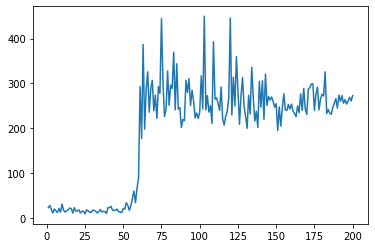

In [16]:
from tqdm import tqdm
num_episodes = 200
episode_returns = []
episode_durations = []
current_timestep = 0 # we should define it outside of the loop to keep track of time
for i_episode in tqdm(range(num_episodes)):

    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    # 2. Run the environment for 1 step using e-greedy policy
    # 3. Add the (state, action, next_state, reward) to replay memory
    # 4. Optimize your q_network for 1 iteration
    #       4.1 Sample one batch from replay memory
    #       4.2 Compute predicted state-action values using q_network
    #       4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
    #       4.4 Compute loss function and optimize q_network for 1 step
    # 5. Soft update the weights of target_network
    #       θ′ ← τ θ + (1 −τ )θ′
    #       θ   is q_network weights
    #       θ′  is target_network weights            
    # 6. Keep track of the total reward for each episode to plot later
    memory_unit = namedtuple('memory_unit',('state', 'action', 'state_prime', 'reward','flag')) #named tuple to save variable in more organized way, we can also merge them after sampling batches to work easier with them
    # Part one, starting a new episode
    state,_ = env.reset()
    state = torch.tensor(state,dtype = torch.float32,device = DEVICE).unsqueeze(0) # unsqueeze for batching
    counter_episod_len = 1
    reward_episode = 0
    while(True):
      # part two: Run the environment for 1 step using e-greedy policy
      action = e_greedy_policy(q_network,state,current_timestep)
      state_prime, reward, terminated, truncated, _ = env.step(action.item())
      reward_episode += reward
      counter_episod_len +=1
      reward = torch.tensor([reward],dtype = torch.float32,device = DEVICE)
      state_prime = torch.tensor(state_prime,dtype = torch.float32,device = DEVICE).unsqueeze(0) # unsqueeze for batching
      # we need to specify final state, so we can assing zero value to that state 
      if terminated:
        flag = torch.tensor([0],dtype =torch.bool,device = DEVICE)
        
      else:
        flag = torch.tensor([1],dtype =torch.bool,device = DEVICE)
      # part three: adding to replay memory, we also added a new variable called flag as indicator for terminating estates
      memory_unit_sample = memory_unit(state,action,state_prime,reward,flag)
      memory.push(memory_unit_sample)
      state = state_prime
      current_timestep +=1
      # start of part four
      # if we are in first episodes, our memory doesn't have 128 sample yet so we have to select batch based on length of our memory
      if len(memory) < BATCH_SIZE:
        batch_size_selected = len(memory)
      else:
        batch_size_selected = BATCH_SIZE
      batch_sampled = memory.sample(batch_size_selected)
      batch = memory_unit(*zip(*batch_sampled)) #merging as a single namedtuple
      state_selected = batch.state  #extracting parameters that we need
      state_selected = torch.cat(state_selected) #concating same parameters to form a tensor for training
      action_selected = batch.action
      action_selected = torch.cat(action_selected)
      state_prime_selected = batch.state_prime
      state_prime_selected = torch.cat(state_prime_selected)
      reward_selected = batch.reward
      reward_selected = torch.cat(reward_selected)
      flag_selected = batch.flag
      flag_selected = torch.cat(flag_selected)
      state_prime_selected = state_prime_selected[flag_selected] #we don't need next state when it's terminating estate, because we know it value should be zero
      Q_all_estimate = q_network(state_selected) # Q value in different states for all values, network is action out so it just need state as input and output Q(a|s)
      Q_action_selected = torch.gather(Q_all_estimate,1,action_selected) # choose only action that we perform to update it value
      Q_greedy_next = torch.zeros(batch_size_selected,device = DEVICE,dtype = torch.float32)
      with torch.no_grad():
          Q_greedy_next[flag_selected] = target_network(state_prime_selected).max(1)[0] # in Q learning, we follow greedy policy so we should choose maximum value as estimation for Q next state
                                                                                        
      estimation_train = reward_selected + GAMMA*Q_greedy_next
      #using MSE loss
      MSE_loss = nn.MSELoss()
      loss = MSE_loss(Q_action_selected.squeeze(), estimation_train)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # final part:now we have to update student model
      q_network_w = q_network.state_dict()
      target_network_w = target_network.state_dict()
      for layer in q_network_w:
        target_network_w[layer] = TAU*q_network_w[layer] + (1-TAU)*target_network_w[layer]
      target_network.load_state_dict(target_network_w)

      if (terminated or truncated):
        episode_returns.append(reward_episode)
        episode_durations.append(counter_episod_len)
        break


    # ==================================== Your Code (End) ====================================  

print('Complete')
plt.plot(range(1, num_episodes+1), episode_durations)

Text(0.5, 1.0, 'returned reward')

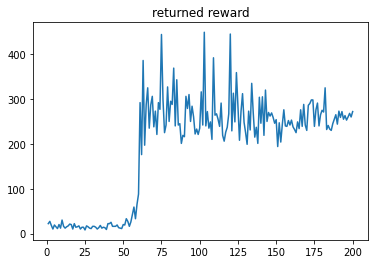

In [17]:
plt.plot(range(1, num_episodes+1), episode_returns)
plt.title('returned reward')

episode reward and length are same!(every step that isn't terminating step has reward = 1)

In [18]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "trained_agent")

**important note**:as we can see, with default parameters in code, it learns quite good, but if we train for more episodes it can perform task perfect (without failing the task) we added next part to train for 300 more episodes and showed results

### Extra test
if we train network for arounf 500 episodes, model can learn to perform task very well and without failing, to show that we train model for 300 more episodes and then show that our estatment is tru

In [19]:
from tqdm import tqdm
num_episodes = 300
for i_episode in tqdm(range(num_episodes)):

    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    # 2. Run the environment for 1 step using e-greedy policy
    # 3. Add the (state, action, next_state, reward) to replay memory
    # 4. Optimize your q_network for 1 iteration
    #       4.1 Sample one batch from replay memory
    #       4.2 Compute predicted state-action values using q_network
    #       4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
    #       4.4 Compute loss function and optimize q_network for 1 step
    # 5. Soft update the weights of target_network
    #       θ′ ← τ θ + (1 −τ )θ′
    #       θ   is q_network weights
    #       θ′  is target_network weights            
    # 6. Keep track of the total reward for each episode to plot later
    memory_unit = namedtuple('memory_unit',('state', 'action', 'state_prime', 'reward','flag')) #named tuple to save variable in more organized way, we can also merge them after sampling batches to work easier with them
    # Part one, starting a new episode
    state,_ = env.reset()
    state = torch.tensor(state,dtype = torch.float32,device = DEVICE).unsqueeze(0) # unsqueeze for batching
    counter_episod_len = 1
    reward_episode = 0
    while(True):
      # part two: Run the environment for 1 step using e-greedy policy
      action = e_greedy_policy(q_network,state,current_timestep)
      state_prime, reward, terminated, truncated, _ = env.step(action.item())
      reward_episode += reward
      counter_episod_len +=1
      reward = torch.tensor([reward],dtype = torch.float32,device = DEVICE)
      state_prime = torch.tensor(state_prime,dtype = torch.float32,device = DEVICE).unsqueeze(0) # unsqueeze for batching
      # we need to specify final state, so we can assing zero value to that state 
      if terminated:
        flag = torch.tensor([0],dtype =torch.bool,device = DEVICE)
        
      else:
        flag = torch.tensor([1],dtype =torch.bool,device = DEVICE)
      # part three: adding to replay memory, we also added a new variable called flag as indicator for terminating estates
      memory_unit_sample = memory_unit(state,action,state_prime,reward,flag)
      memory.push(memory_unit_sample)
      state = state_prime
      current_timestep +=1
      # start of part four
      # if we are in first episodes, our memory doesn't have 128 sample yet so we have to select batch based on length of our memory
      if len(memory) < BATCH_SIZE:
        batch_size_selected = len(memory)
      else:
        batch_size_selected = BATCH_SIZE
      batch_sampled = memory.sample(batch_size_selected)
      batch = memory_unit(*zip(*batch_sampled)) #merging as a single namedtuple
      state_selected = batch.state  #extracting parameters that we need
      state_selected = torch.cat(state_selected) #concating same parameters to form a tensor for training
      action_selected = batch.action
      action_selected = torch.cat(action_selected)
      state_prime_selected = batch.state_prime
      state_prime_selected = torch.cat(state_prime_selected)
      reward_selected = batch.reward
      reward_selected = torch.cat(reward_selected)
      flag_selected = batch.flag
      flag_selected = torch.cat(flag_selected)
      state_prime_selected = state_prime_selected[flag_selected] #we don't need next state when it's terminating estate, because we know it value should be zero
      Q_all_estimate = q_network(state_selected) # Q value in different states for all values, network is action out so it just need state as input and output Q(a|s)
      Q_action_selected = torch.gather(Q_all_estimate,1,action_selected) # choose only action that we perform to update it value
      Q_greedy_next = torch.zeros(batch_size_selected,device = DEVICE,dtype = torch.float32)
      with torch.no_grad():
          Q_greedy_next[flag_selected] = target_network(state_prime_selected).max(1)[0] # in Q learning, we follow greedy policy so we should choose maximum value as estimation for Q next state
                                                                                        
      estimation_train = reward_selected + GAMMA*Q_greedy_next
      #using MSE loss
      MSE_loss = nn.MSELoss()
      loss = MSE_loss(Q_action_selected.squeeze(), estimation_train)

      optimizer.zero_grad()
      loss.backward()
      # updating network
      optimizer.step()

      # final part:now we have to update student model
      q_network_w = q_network.state_dict()
      target_network_w = target_network.state_dict()
      for layer in q_network_w:
        target_network_w[layer] = TAU*q_network_w[layer] + (1-TAU)*target_network_w[layer]
      target_network.load_state_dict(target_network_w)

      if (terminated or truncated):
        episode_returns.append(reward_episode)
        episode_durations.append(counter_episod_len)
        break


    # ==================================== Your Code (End) ====================================  

print('Complete')


100%|██████████| 300/300 [11:04<00:00,  2.22s/it]

Complete


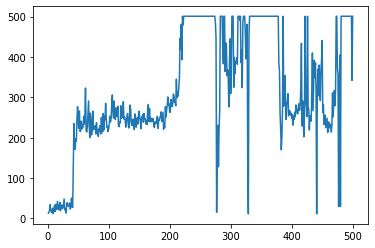

In [ ]:
plt.plot(range(1, 500+1), episode_durations)

In [20]:
def create_policy_eval_video_limited(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if (terminated or truncated) :
                    break
    return embed_mp4(filename)

In [21]:
create_policy_eval_video_limited(env, lambda s: greedy_policy(q_network, s), "trained_agent")

as we can see it performs task without dropping it or getting out of borders.(we just plotted it for 16 seconds but it can hold it for a long long time)